In [6]:
import pandas as pd
import seaborn as sns

import numpy as np
import scipy.stats as ss
from scipy.stats import norm

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
df = pd.read_csv('hw_aa.csv', sep = ';')

In [8]:
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [9]:
df.dtypes

Unnamed: 0            int64
uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [10]:
df.isna().sum()

Unnamed: 0           0
uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

In [11]:
df.shape

(127018, 5)

# **A/A-тест**

100%|██████████| 1000/1000 [00:28<00:00, 34.52it/s]


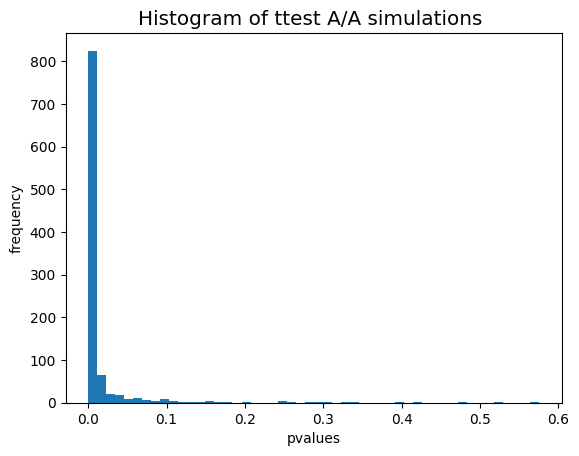

np.float64(0.935)

In [12]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    vec_1 = df[df.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    vec_2 = df[df.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    res.append(ss.ttest_ind(vec_1, vec_2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

FPR больше альфы! И распределение явно не уложится в равномерное теоретическое распределение α. Нужно искать причины поломки.

**Ищем причины поломки сплит-системы, ориентируясь на результаты эксперимента**

Посчитаем конверсию

In [19]:
df_conversion = df\
    .groupby(['experimentVariant', 'version'], as_index=False)\
    .agg({'uid': 'count', 'purchase': 'sum'})

In [20]:
df_conversion['conversion'] = df_conversion.purchase / df_conversion.uid

In [21]:
df_conversion

,experimentVariant,version,uid,purchase,conversion
0,0,v2.8.0,41283,41,0.000993
1,0,v2.9.0,11921,890,0.074658
2,0,v3.7.4.0,4204,252,0.059943
3,0,v3.8.0.0,5694,328,0.057604
4,1,v2.8.0,41552,1895,0.045606
5,1,v2.9.0,12033,858,0.071304
6,1,v3.7.4.0,4221,266,0.063018
7,1,v3.8.0.0,6110,384,0.062848


<Axes: xlabel='version', ylabel='conversion'>

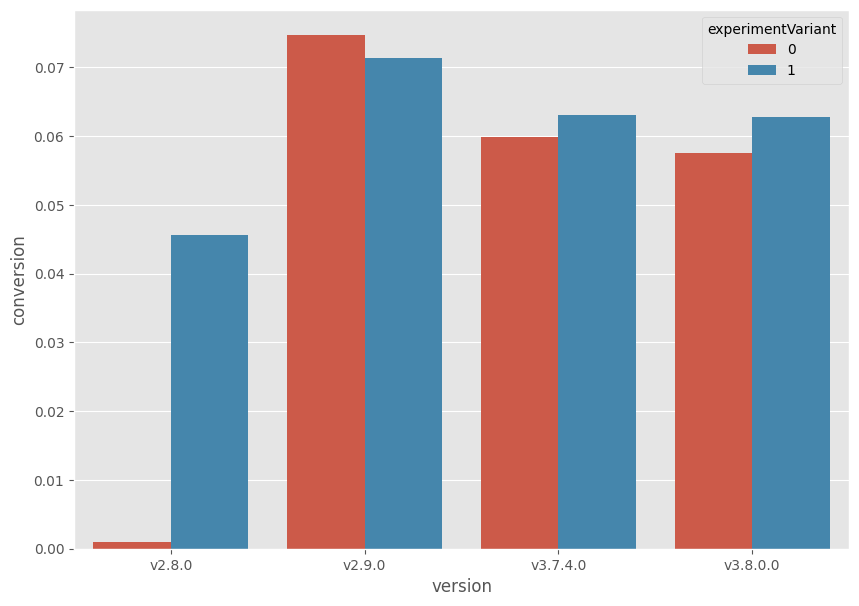

In [24]:
plt.figure(figsize=(10, 7))
sns.barplot(data = df_conversion, x = 'version', y='conversion', hue = 'experimentVariant')

Тут уже видно что группы v2.8.0 сильно отличается по конверсии от остальных

Для проверки средних в группах по версиям будем использовать t-test.

In [25]:
v_2_8_0_contol = df.query('version == "v2.8.0" and experimentVariant == 0')
v_2_8_0_test = df.query('version == "v2.8.0" and experimentVariant == 1')

In [29]:
ss.ttest_ind(v_2_8_0_contol.purchase, v_2_8_0_test.purchase)

TtestResult(statistic=np.float64(-42.963540840360324), pvalue=np.float64(0.0), df=np.float64(82833.0))

Обнаружено значительное статистическое различие

In [27]:
v_2_9_0_contol = df.query('version == "v2.9.0" and experimentVariant == 0')
v_2_9_0_test = df.query('version == "v2.9.0" and experimentVariant == 1')

In [28]:
ss.ttest_ind(v_2_9_0_contol.purchase, v_2_9_0_test.purchase)

TtestResult(statistic=np.float64(0.9979597634962479), pvalue=np.float64(0.3183089516720744), df=np.float64(23952.0))

In [31]:
v_3_7_4_0_contol = df.query('version == "v3.7.4.0" and experimentVariant == 0')
v_3_7_4_0_test = df.query('version == "v3.7.4.0" and experimentVariant == 1')

In [32]:
ss.ttest_ind(v_3_7_4_0_contol.purchase, v_3_7_4_0_test.purchase)

TtestResult(statistic=np.float64(-0.5874925850487471), pvalue=np.float64(0.5568886771079735), df=np.float64(8423.0))

In [33]:
v_3_8_0_0_contol = df.query('version == "v3.8.0.0" and experimentVariant == 0')
v_3_8_0_0_test = df.query('version == "v3.8.0.0" and experimentVariant == 1')

In [34]:
ss.ttest_ind(v_3_8_0_0_contol.purchase, v_3_8_0_0_test.purchase)

TtestResult(statistic=np.float64(-1.1956188950206779), pvalue=np.float64(0.23186933664059722), df=np.float64(11802.0))

Видим что **причина поломки A/A теста кроется в данных МП версии 2.8.0**

Проведем повторный A/A тест искоючив аномалию

In [35]:
df_final = df\
    .query('version != "v2.8.0"')

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:12<00:00, 79.29it/s]


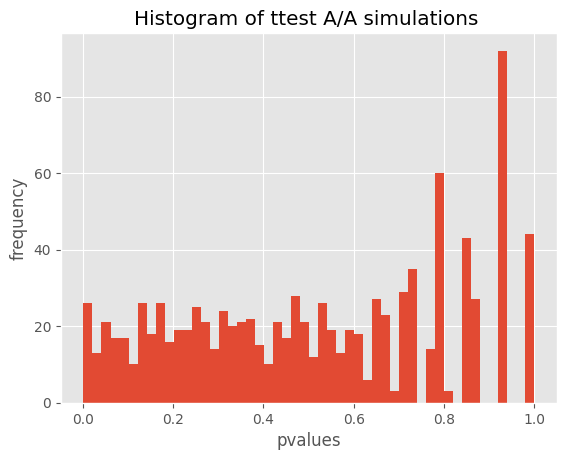

np.float64(0.046)

In [36]:
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    vec_1 = df_final[df_final.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    vec_2 = df_final[df_final.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    res.append(ss.ttest_ind(vec_1, vec_2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

**FPR не привыешает альфу, система сплитования корректна**